In [2]:
from main import *

import matplotlib.pyplot as plt
from brainspace.gradient.embedding import DiffusionMaps
from scipy.stats import pearsonr, spearmanr

plt.rcParams['font.size'] = 18

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)

cuda:0


# Testing the effect of network size

In [3]:
rule = 'gaussian'
sigma = 0.05
g = 2
alpha = 7.5
beta = 0.5
tau = 3

In [4]:
N_values = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
N_values

[100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

In [12]:
corr_matrices, connectomes, ids = [], [], []

for N in N_values:
    
    vertices = np.load('vertices_heart.npy').astype('float')
    order = np.argsort(vertices[:, 0])
    vertices = vertices[order]
    eigenmodes = np.load('eigenmodes_heart.npy')[order]
    
    vertices -= np.min(vertices)
    vertices /= np.max(vertices)
    
    random_ids = [1] * N + [0] * (vertices.shape[0] - N)
    ids.append(random_ids)
    
    np.random.shuffle(random_ids)
    coords = vertices[np.array(random_ids) == 1]

    A, W = np.zeros((N, N)), np.zeros((N, N))
    
    for i in tqdm(range(100), file=sys.stdout):

        rnn = RNN(N, coords, g=g, tau=tau, alpha=alpha, beta=beta, rule=rule, sigma=sigma)
        R = rnn.forward(1000)
        
        corr = torch.corrcoef(R).detach().cpu().numpy()
        w = rnn.W.detach().cpu().numpy()
        
        # Numpy implementation
        #R = np.concatenate(rnn.R, axis=1)
        #corr = torch.corrcoef(torch.tensor(R).to('cuda:0')).detach().cpu().numpy()
        #w = rnn.W
        
        A = (np.abs(A) * (i / (1 + i))) + (np.abs(corr) * (1 / (i + 1)))
        W = (np.abs(W) * (i / (1 + i))) + (np.abs(w) * (1 / (i + 1)))

    corr_matrices.append(A)
    connectomes.append(W)
    np.save('Matrices_Heart/corr_matrix_N{}.npy'.format(N), A)
    np.save('Matrices_Heart/connectome_N{}.npy'.format(N), W)
    np.save('Matrices_Heart/random_ids_N{}.npy'.format(N), random_ids)

100%|█████████████████████████████████████████| 100/100 [04:03<00:00,  2.43s/it]


#### Comparing eigenmodes

In [15]:
from scipy.optimize import linear_sum_assignment

In [16]:
ids, connectomes, corr_matrices = [], [], []
for N in N_values:
    corr_matrices.append(np.load('Matrices_Heart/corr_matrix_N{}.npy'.format(N)))
    connectomes.append(np.load('Matrices_Heart/connectome_N{}.npy'.format(N)))
    ids.append(np.load('Matrices_Heart/random_ids_N{}.npy'.format(N)))

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


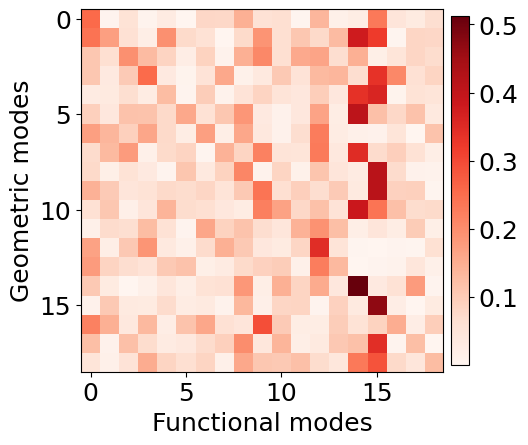

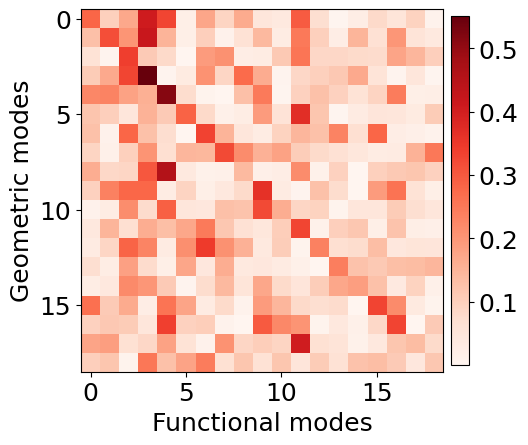

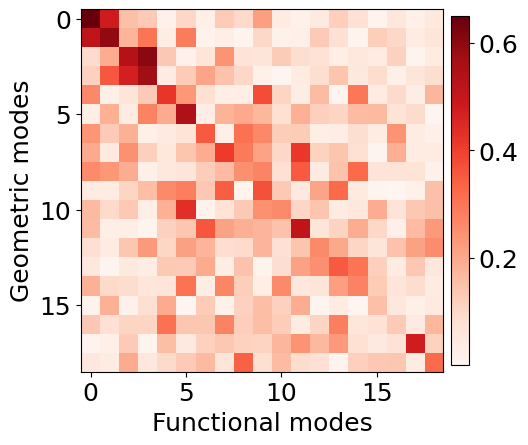

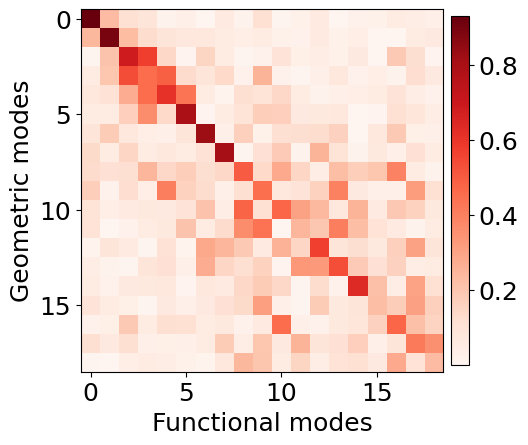

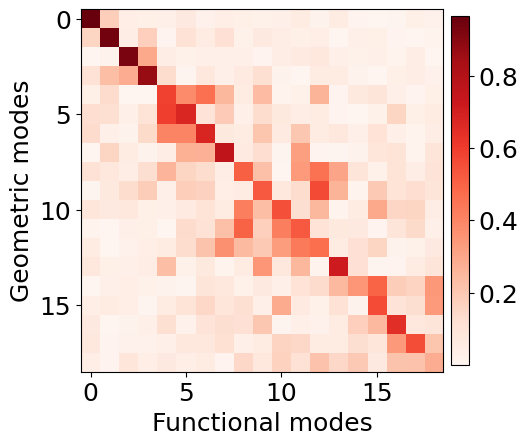

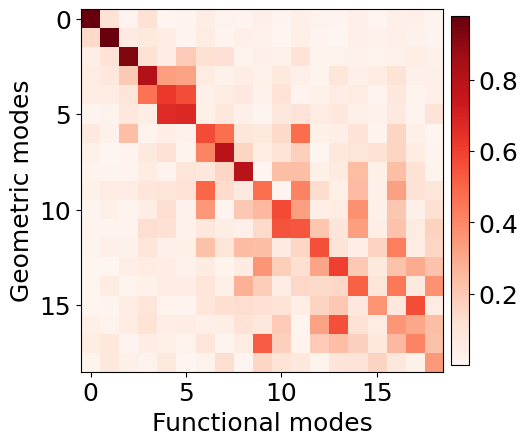

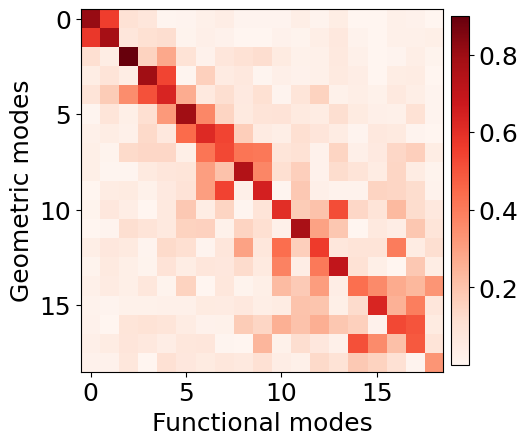

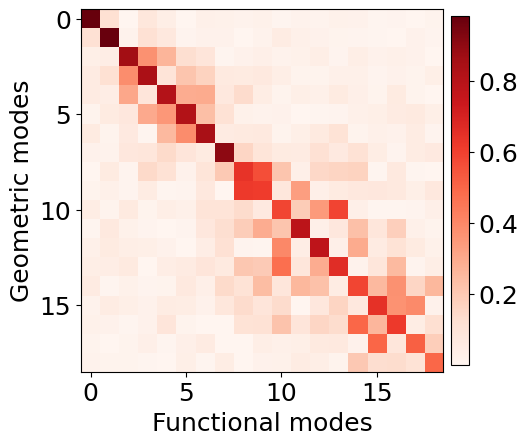

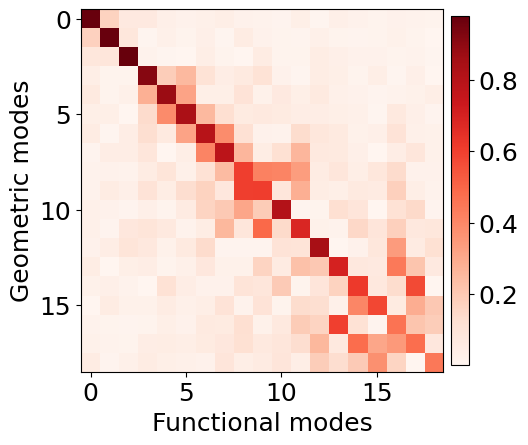

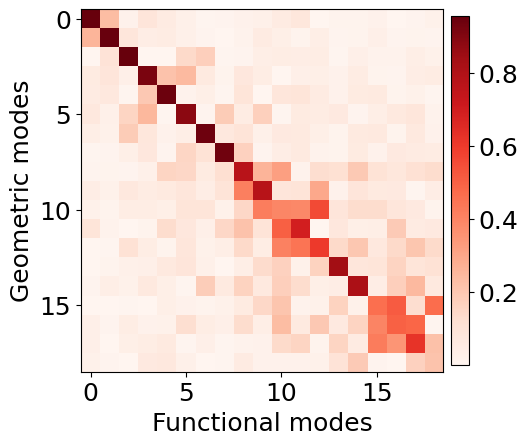

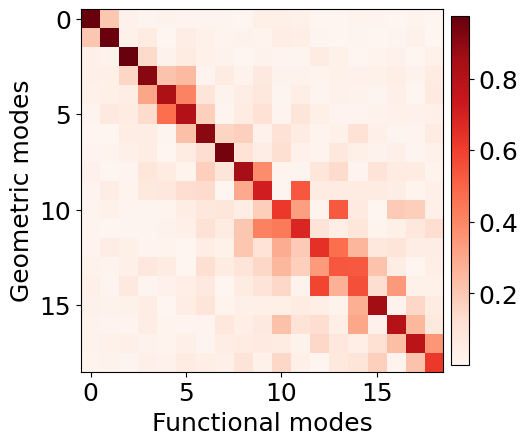

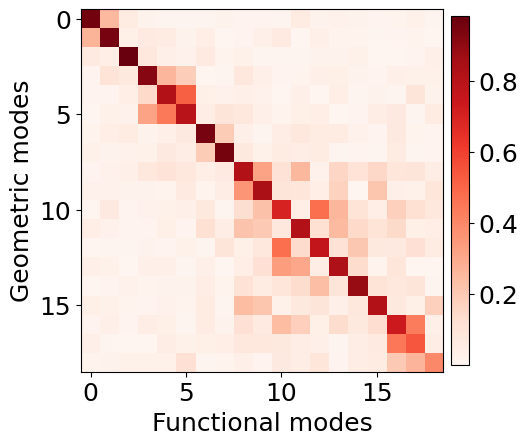

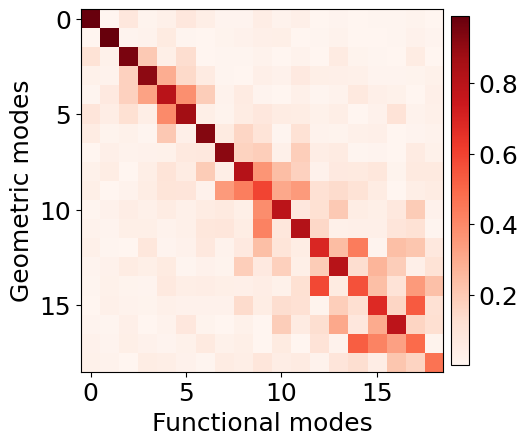

In [17]:
mode_correlations = []

for i in range(len(connectomes)):

    FC = np.abs(corr_matrices[i])
    SC = np.abs(connectomes[i])
    random_ids = ids[i]
    
    map = DiffusionMaps(n_components = 20)
    embeddingf = map.fit_transform(np.abs(FC))
    map = DiffusionMaps(n_components = 20)
    embeddings = map.fit_transform(np.abs(SC + SC.T))

    modes_f, modes_s = [], []
    for i in range(20):
        modes_f.append(embeddingf[:, i].flatten())
        modes_s.append(embeddings[:, i].flatten())

    geometric_modes = eigenmodes[np.array(random_ids) == 1, :].T
    N_modes = len(modes_f)
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            corrs[i, j] = pearsonr(geometric_modes[i], modes_f[j])[0]
            
    cost_matrix = 1 - np.abs(corrs)
    _, mapping = linear_sum_assignment(cost_matrix)

    N_modes = len(modes_f)
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            corrs[i, j] = pearsonr(geometric_modes[i], modes_f[mapping[j]])[0]

    fig, ax = plt.subplots(figsize=(5, 5))
    cax = plt.imshow(np.abs(corrs)[1:, 1:], cmap='Reds')
    plt.xlabel('Functional modes')
    plt.ylabel('Geometric modes')
    plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
    plt.show()

    mode_correlations.append(np.abs(corrs[1:, 1:][np.diag_indices(19)]))

In [18]:
means = []
for m in mode_correlations:
    means.append(np.mean(m))

Text(0.5, 0, '$N$')

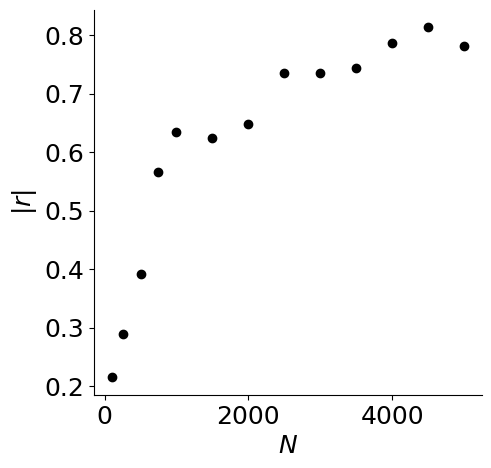

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(N_values, means, color='black')
ax.spines[['top', 'right']].set_visible(False)
plt.ylabel(r"$|r|$")
plt.xlabel(R"$N$")

In [2]:
x = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
y = [0.21, 0.28, 0.39, 0.57, 0.64, 0.63, 0.66, 0.75, 0.75, 0.76, 0.8, 0.82, 0.79]

In [3]:
plt.scatter(x, y)

NameError: name 'plt' is not defined

# Testing the effect of kernel size

In [20]:
N = 1000

In [21]:
rule = 'gaussian'
sigma = 0.05
g = 2
alpha = 7.5
beta = 0.5
tau = 3

In [22]:
sigma_values = np.linspace(0.01, 0.5, 50)

sigma_values = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

In [23]:
vertices = np.load('vertices_heart.npy').astype('float')
order = np.argsort(vertices[:, 0])
vertices = vertices[order]
eigenmodes = np.load('eigenmodes_heart.npy')[order]

vertices -= np.min(vertices)
vertices /= np.max(vertices)

random_ids = [1] * N + [0] * (vertices.shape[0] - N)
ids.append(random_ids)

np.random.shuffle(random_ids)
coords = vertices[np.array(random_ids) == 1]

corr_matrices, connectomes, ids = [], [], []

for sigma in sigma_values:

    A, W = np.zeros((N, N)), np.zeros((N, N))
    
    for i in tqdm(range(100), file=sys.stdout):

        rnn = RNN(N, coords, g=g, tau=tau, alpha=alpha, beta=beta, rule=rule, sigma=sigma)

        R = rnn.forward(1000)
        corr = torch.corrcoef(R).detach().cpu().numpy()
        w = rnn.W.detach().cpu().numpy()
        
        # Numpy implementation
        #R = np.concatenate(rnn.R, axis=1)
        #corr = torch.corrcoef(torch.tensor(R).to('cuda:0')).detach().cpu().numpy()
        #w = rnn.W
        
        A = (np.abs(A) * (i / (1 + i))) + (np.abs(corr) * (1 / (i + 1)))
        W = (np.abs(W) * (i / (1 + i))) + (np.abs(w) * (1 / (i + 1)))

    corr_matrices.append(A)
    connectomes.append(W)

100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.61it/s]


#### Comparing eigenmodes

In [24]:
from scipy.optimize import linear_sum_assignment

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/brainspace/gradient/embedding.py:95: RuntimeWarning: divide by zero encountered in power
  d = np.power(d, -alpha)
/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/brainspace/gradient/embedding.py:96: RuntimeWarning: invalid value encountered in multiply
  adj *= d.T
/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/brainspace/gradient/embedding.py:97: RuntimeWarning: invalid value encountered in multiply
  adj *= d


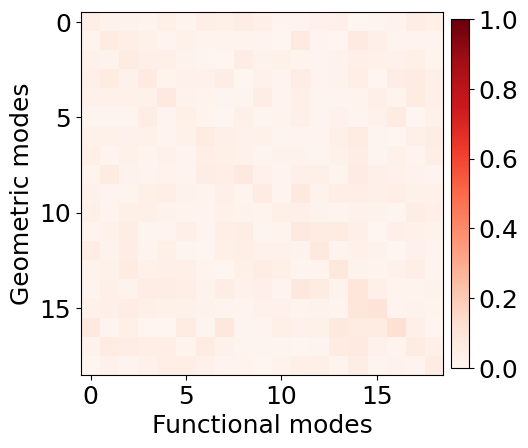

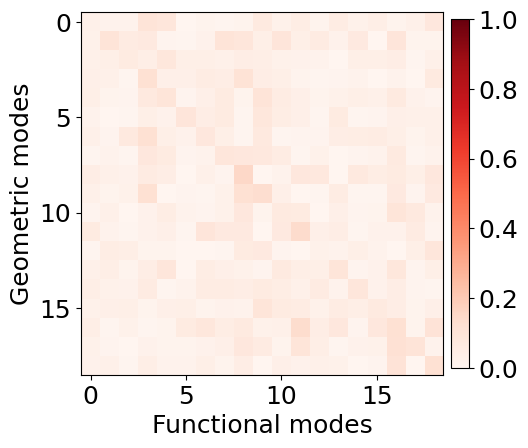

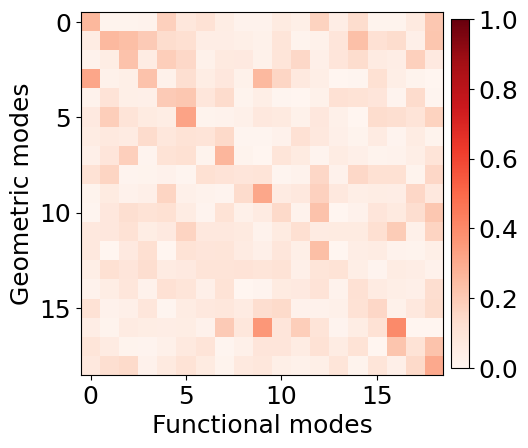

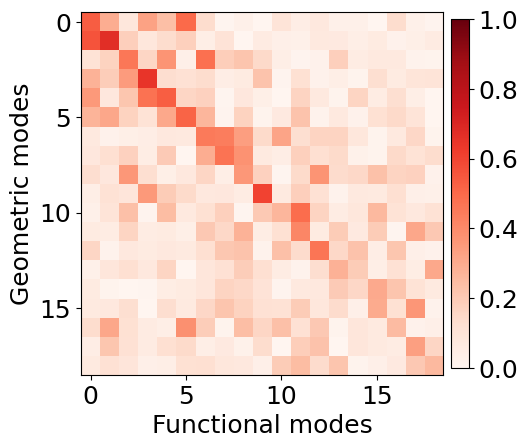

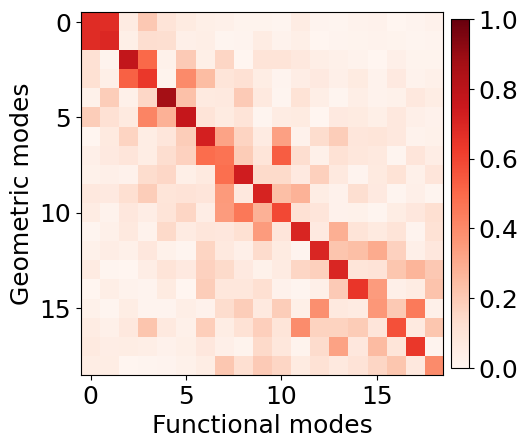

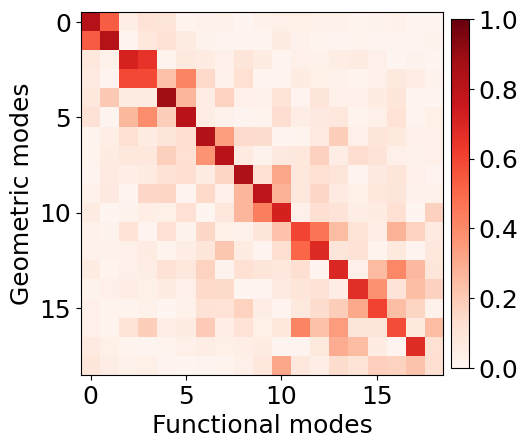

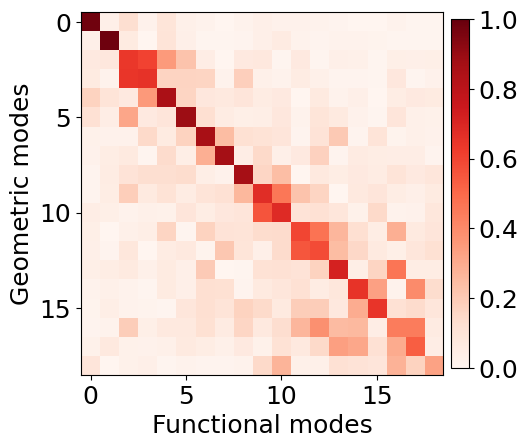

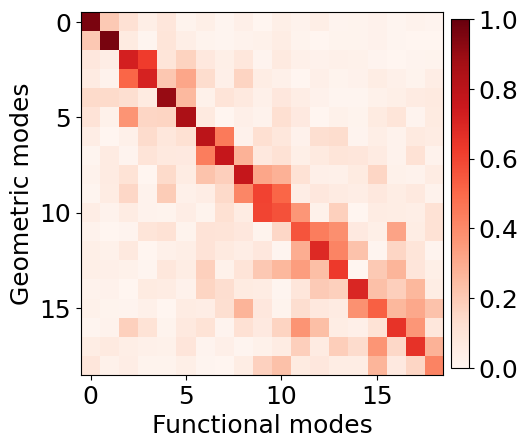

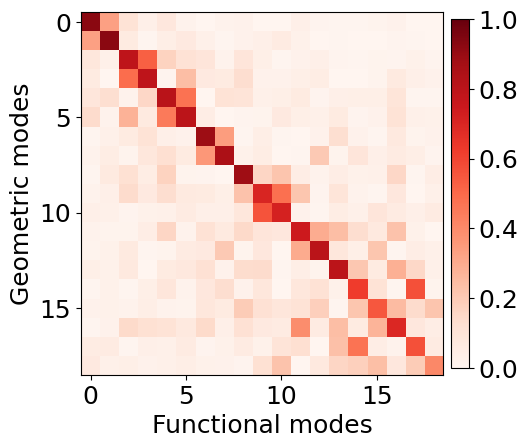

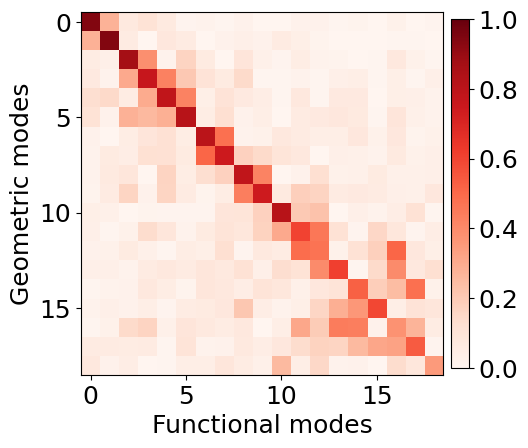

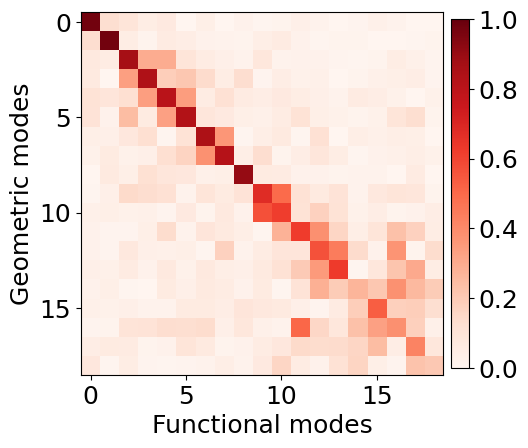

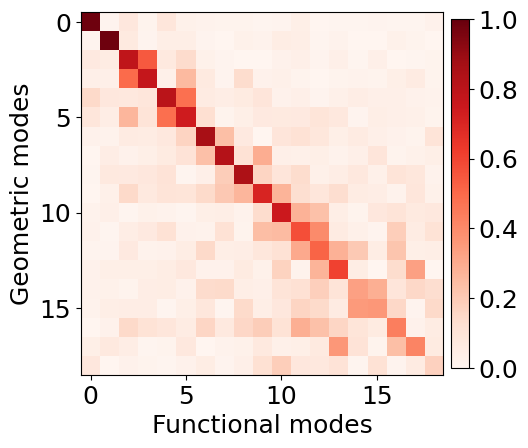

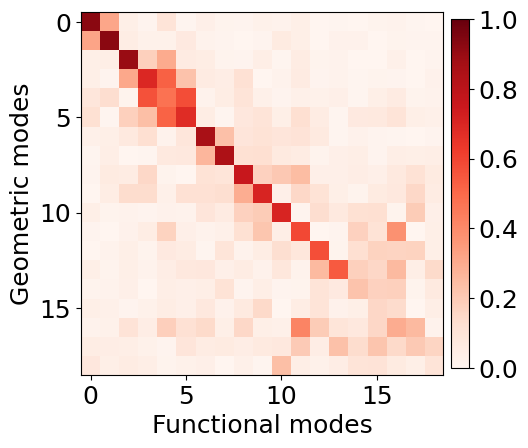

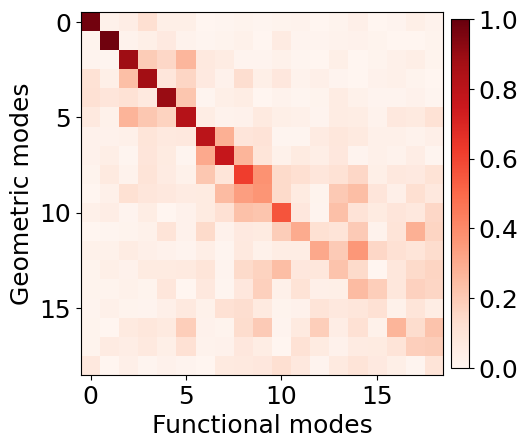

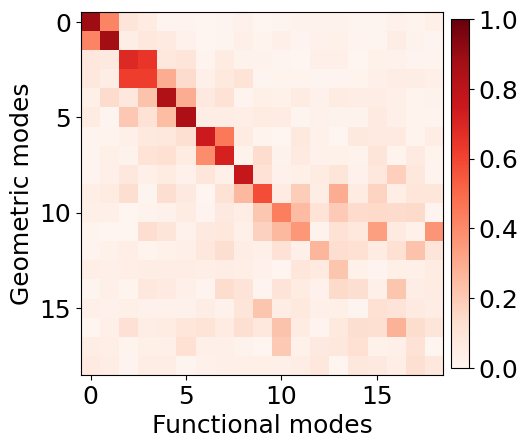

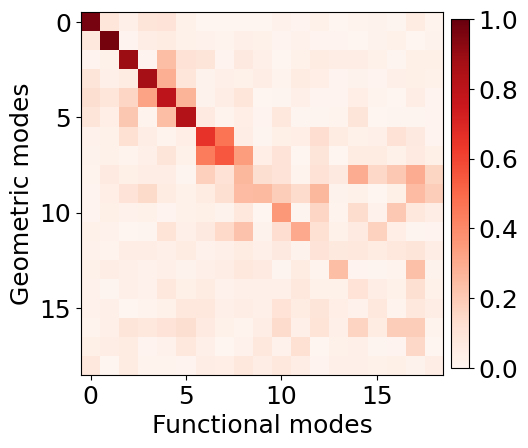

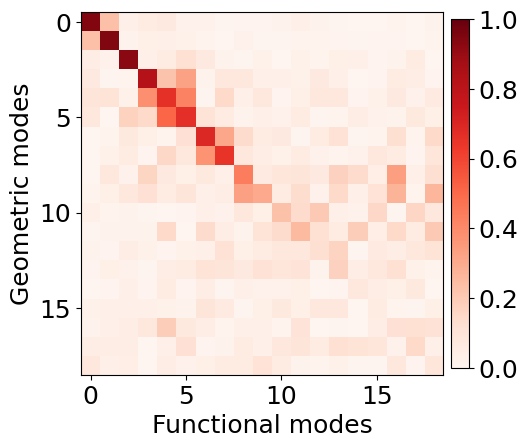

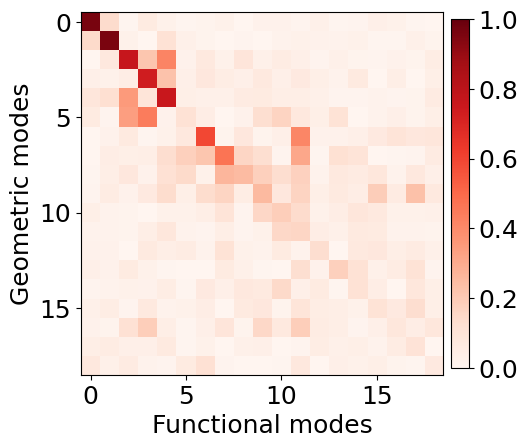

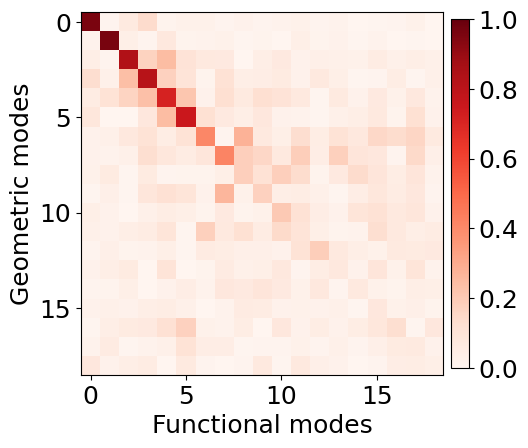

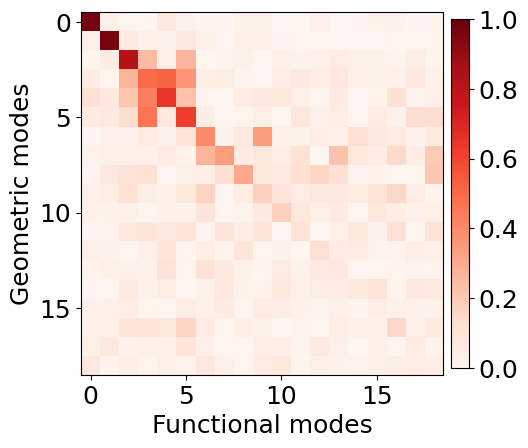

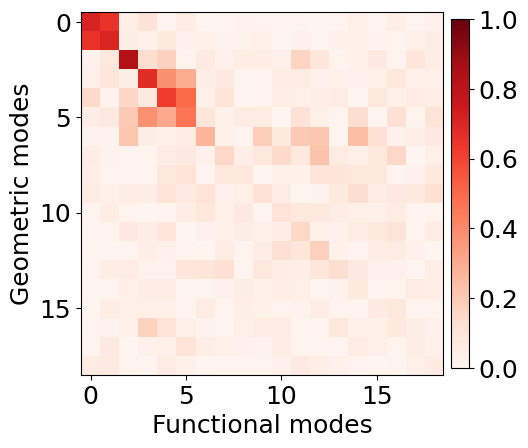

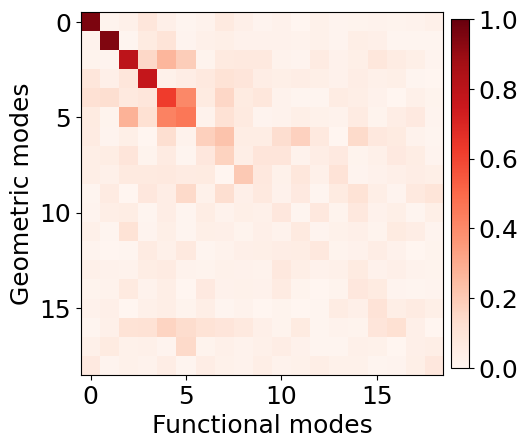

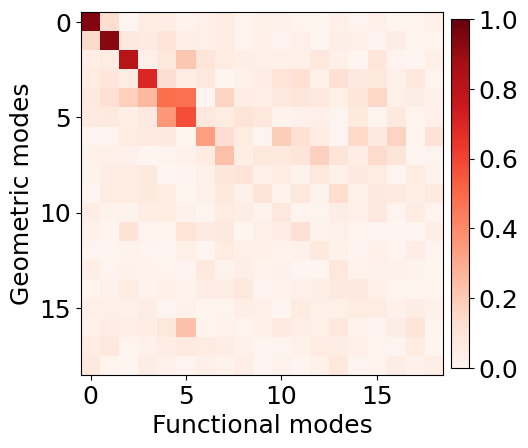

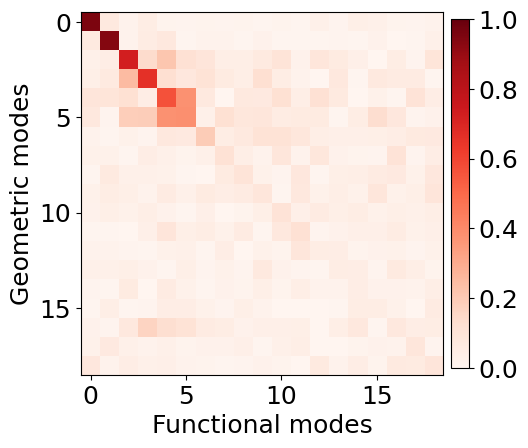

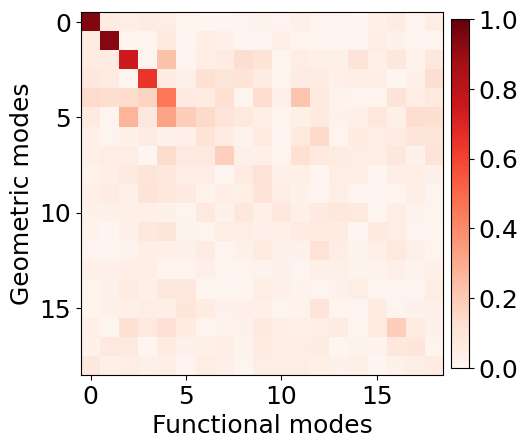

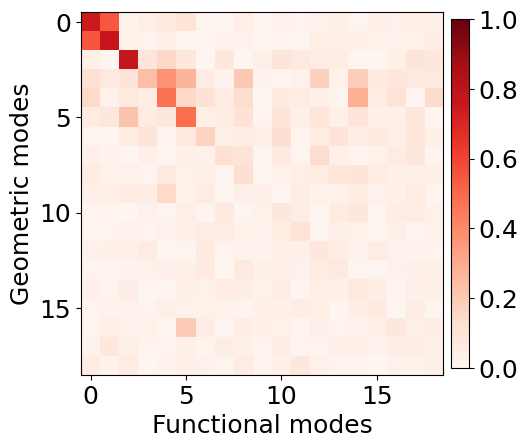

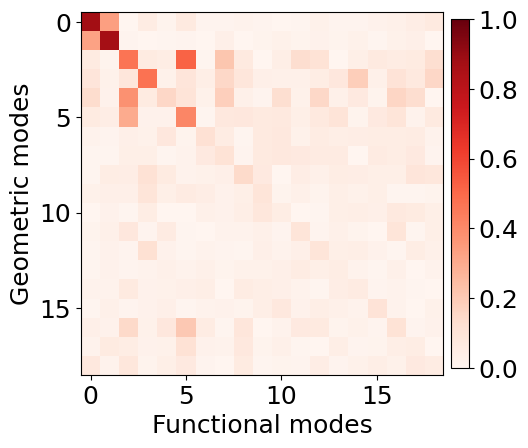

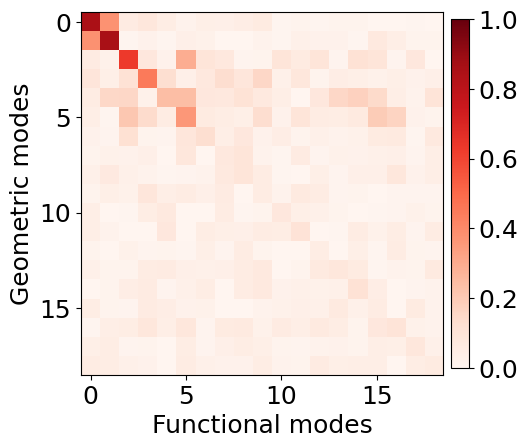

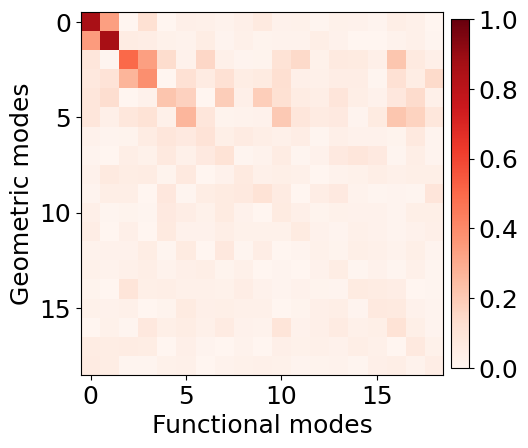

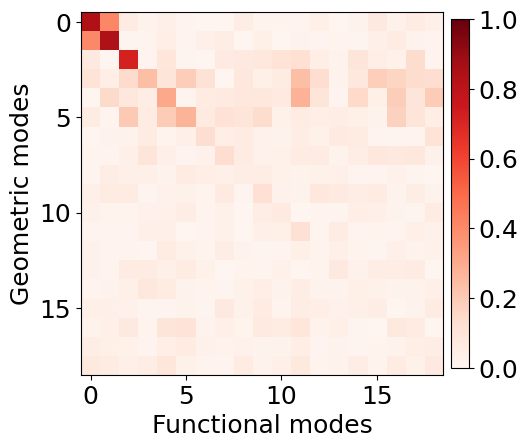

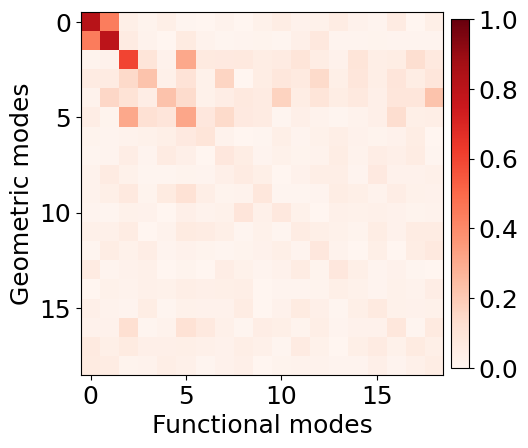

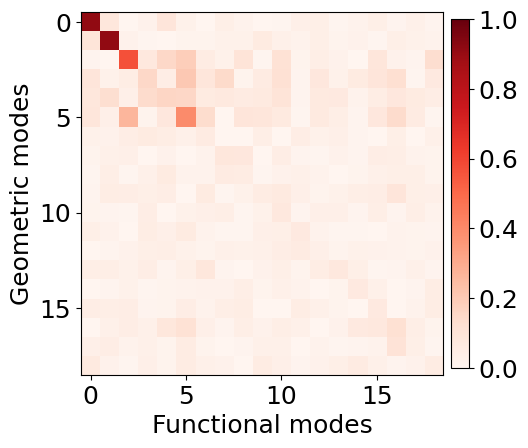

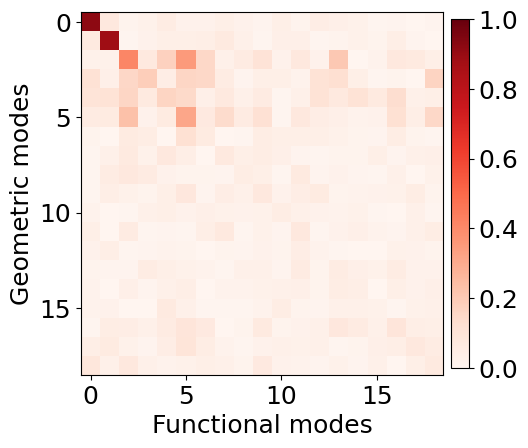

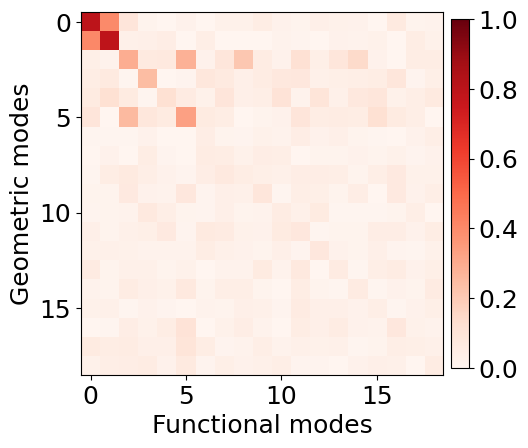

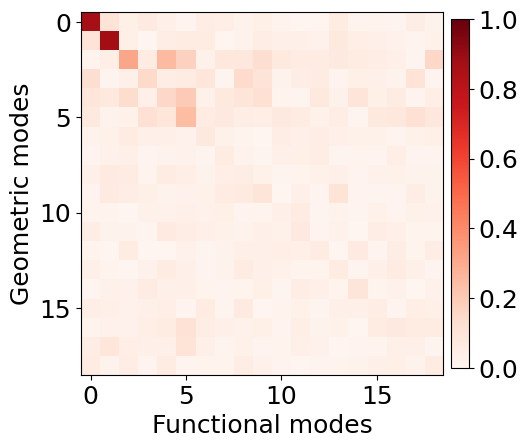

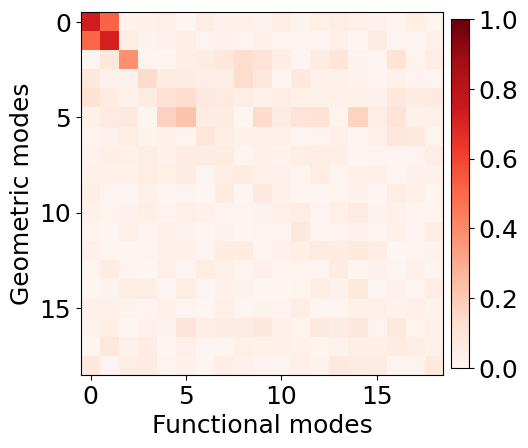

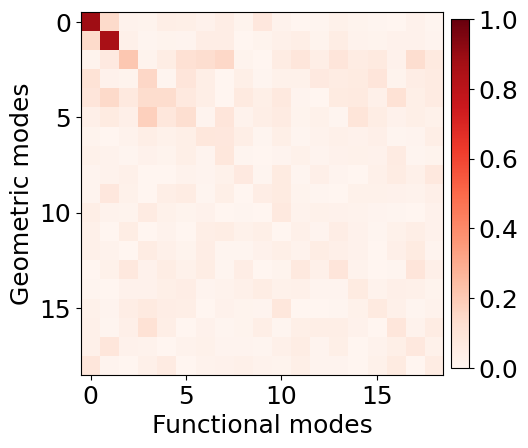

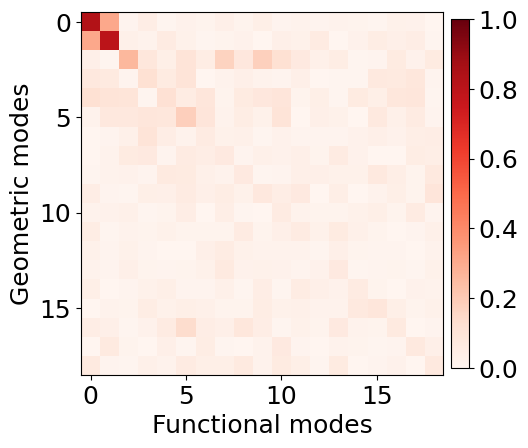

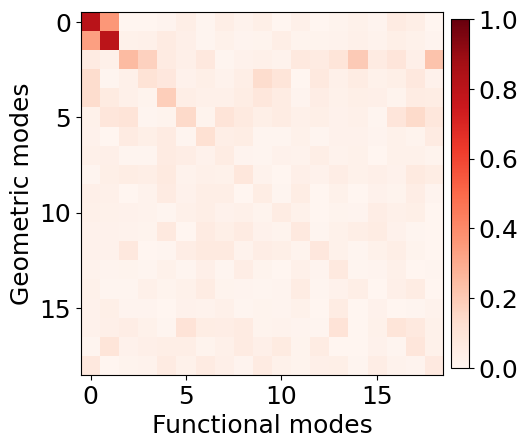

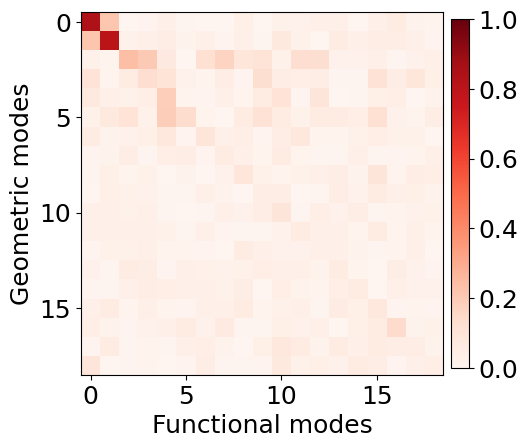

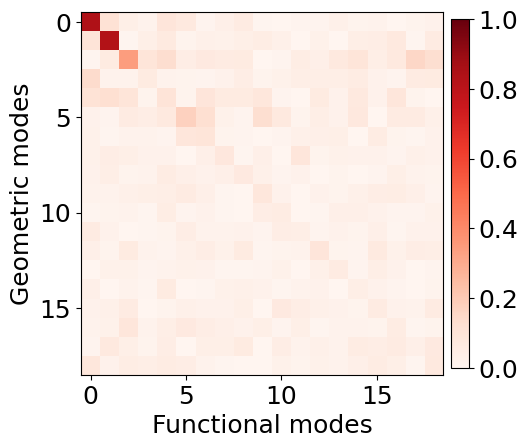

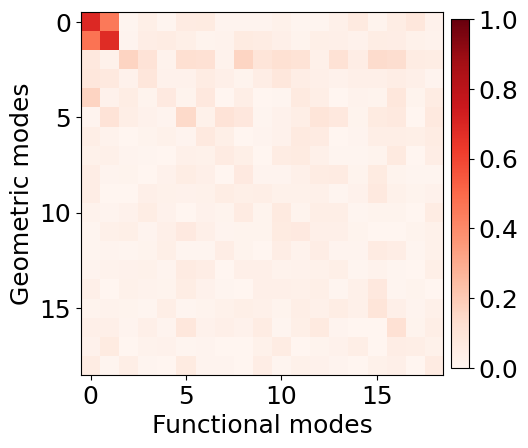

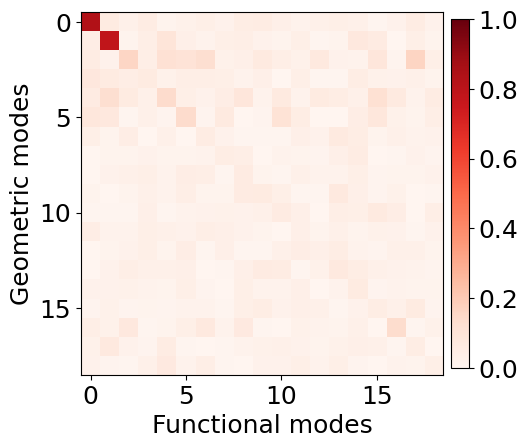

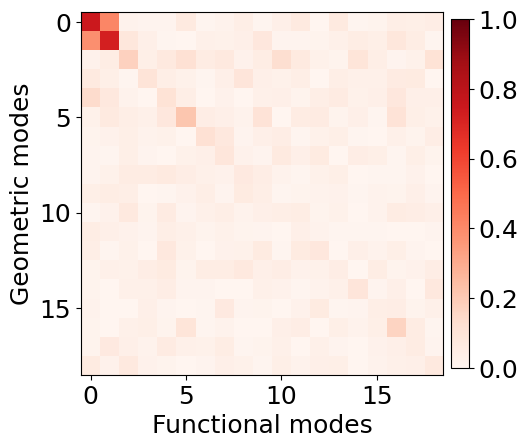

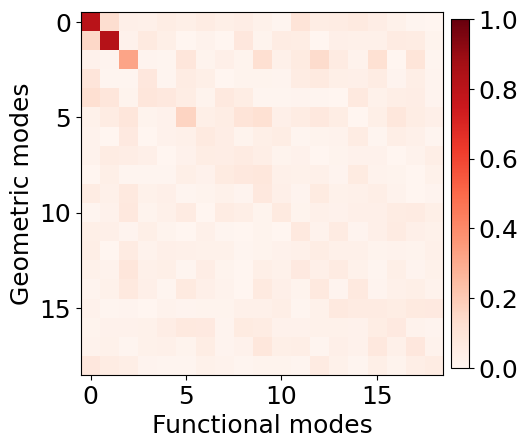

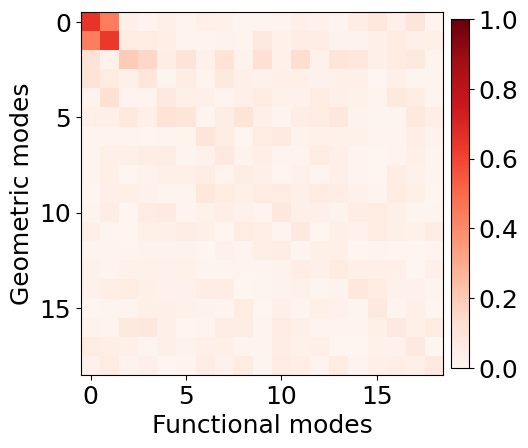

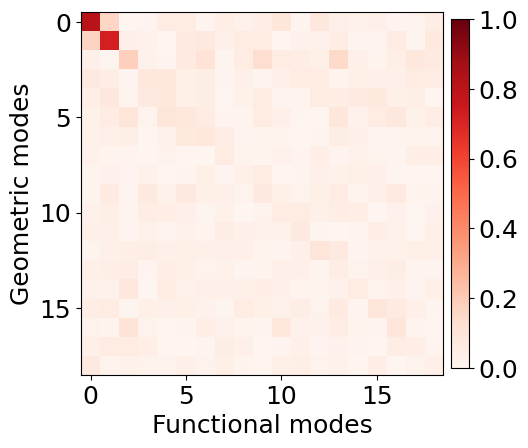

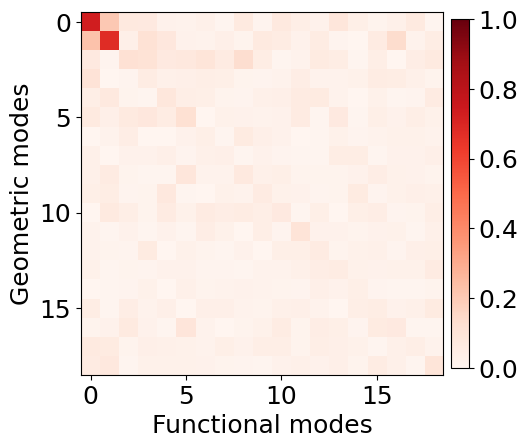

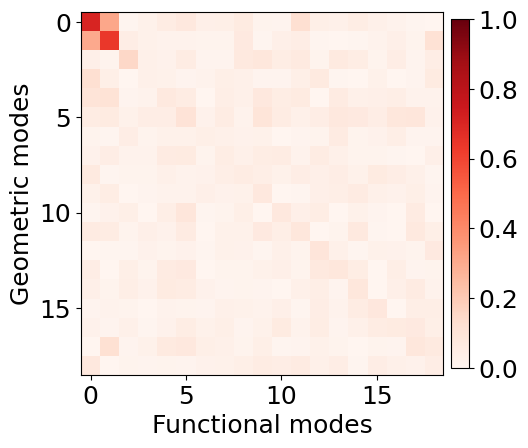

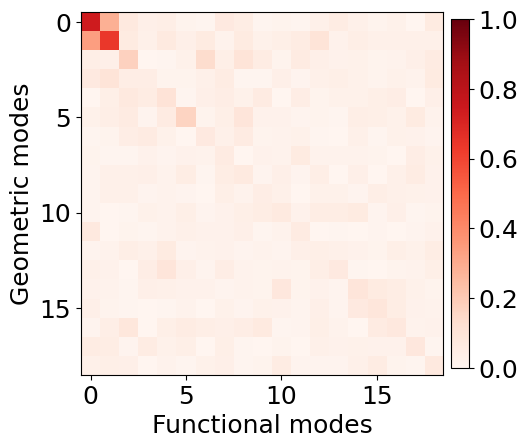

In [25]:
mode_correlations = []

for i in range(len(connectomes)):

    FC = np.abs(corr_matrices[i])
    SC = np.abs(connectomes[i])
    
    map = DiffusionMaps(n_components = 20)
    embeddingf = map.fit_transform(np.abs(FC))
    map = DiffusionMaps(n_components = 20)
    embeddings = map.fit_transform(np.abs(SC + SC.T))

    modes_f, modes_s = [], []
    for i in range(20):
        modes_f.append(embeddingf[:, i].flatten())
        modes_s.append(embeddings[:, i].flatten())

    geometric_modes = eigenmodes[np.array(random_ids) == 1, :].T
    N_modes = len(modes_f)
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            corrs[i, j] = pearsonr(geometric_modes[i], modes_f[j])[0]
            
    cost_matrix = 1 - np.abs(corrs)
    _, mapping = linear_sum_assignment(cost_matrix)

    N_modes = len(modes_f)
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            corrs[i, j] = pearsonr(geometric_modes[i], modes_f[mapping[j]])[0]

    fig, ax = plt.subplots(figsize=(5, 5))
    cax = plt.imshow(np.abs(corrs)[1:, 1:], cmap='Reds', vmin=0, vmax=1)
    plt.xlabel('Functional modes')
    plt.ylabel('Geometric modes')
    plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
    plt.show()

    mode_correlations.append(np.abs(corrs[1:, 1:][np.diag_indices(19)]))

In [26]:
means = []
for m in mode_correlations:
    means.append(np.mean(m))

Text(0.5, 0, '$\\sigma$')

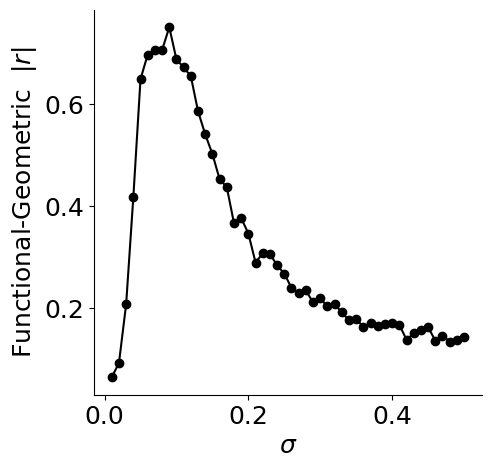

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(sigma_values, means, color='black')
ax.scatter(sigma_values, means, color='black')

ax.spines[['top', 'right']].set_visible(False)
plt.ylabel(r"Functional-Geometric  $|r|$")
plt.xlabel(r"$\sigma$")
#plt.xscale('log')

In [ ]:
x = [0.11, 0.15, 0.2, 0.3, 0.4]

y = [0.78, 0.5, 0.3, 0.2, 0.15]

In [31]:
from scipy.stats import lognorm

In [35]:
coeffs = lognorm.fit(means, loc=0)

In [40]:
values = lognorm(0.5,loc=0,scale=1).rvs(size=5000)